# Notes
**Supposed to be used as a sort of showcase of how to use the tool**

*Unfinished, just a draft*

- Whenever a critical error occurs, we should think of it as also being a corruption error

In [1]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import RegisterTree, Analyses

In [15]:
register_tree = RegisterTree(data_directory="data", data_loading_timeout=120)

print(f"Could read the following files:")
for i, file_name in enumerate(register_tree.no_reg_runs):
    print(f"\t{file_name}")
    if i > 4:
        print("\t.\n\t.\n\t.")
        break

Running function _read_viable_seu_logs. Took: 16.70 seconds
Running function _create_register_tree. Took: 2.73 seconds
Could read the following files:
	seu_2023-09-13_05-48-18.106123
	seu_2023-09-13_05-47-52.279055
	seu_2023-09-13_05-48-14.854977
	seu_2023-09-13_05-48-18.106123
	seu_2023-09-13_05-47-52.279055
	seu_2023-09-13_05-48-14.854977
	.
	.
	.


## Showcase of the register tree
**Do more in the code, add search to tree, maybe show graphviz**

The data is accessed through a tree-structure, which follows the hierarchy of the given SoC. The code below shows some ways of interacting with this data-model

In [17]:
register_name = "ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibex_top.gen_regfile_ff.register_file_i"
# register_name = "ibex_soc_wrap.ibex_soc_i"
node = register_tree.get_node_by_path(register_name)

print(node.soc_path)
print(node.name)
print(f"Number of hits on this element: \n\t{len(node.seu_log)}")

print("Names of children of this node:")
for i, child in enumerate(node.children):
    print("\t", child.name)
    
    if i > 4:
        print("\t.\n\t.\n\t.")
        break

ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibex_top.gen_regfile_ff.register_file_i
register_file_i
Number of hits on this element: 
	3336
Names of children of this node:
	 rf_reg[27]
	 rf_reg[20]
	 rf_reg[4]
	 rf_reg[2]
	 rf_reg[11]
	 rf_reg[18]
	.
	.
	.


In [34]:
mem0_name = "ibex_soc_wrap.ibex_soc_i.mem0"
mem0_node = register_tree.get_node_by_path(mem0_name)
mem0_node.seu_log

,injection_cycle,register,bit_number,value_before,value_after,seed_crc,list_crc,matrix_crc,state_crc,final_crc,coremark_score
seu_2023-09-12_05-40-19.450607,99826,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,1,0,2,59893,59156,8151,36410,59156,4640560
seu_2023-09-11_16-59-04.096565,202406,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,2,0,4,59893,59156,8151,36410,59156,4640560
seu_2023-09-12_02-00-21.080257,364095,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,17,0,131072,59893,59156,8151,36410,59156,4640560
seu_2023-09-12_19-45-04.890708,390958,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutA,14,5024387,5040771,None,None,None,None,None,None
seu_2023-09-12_19-12-20.617988,348821,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,8,0,256,59893,59156,8151,36410,59156,4640560
...,...,...,...,...,...,...,...,...,...,...,...
seu_2023-09-11_17-08-02.432552,54319,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,5,0,32,59893,59156,8151,36410,59156,4640560
seu_2023-09-12_16-55-50.519789,278627,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,8,0,256,59893,59156,8151,36410,59156,4640560
seu_2023-09-12_05-24-36.523824,24416,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,23,0,8388608,59893,59156,8151,36410,59156,4640560
seu_2023-09-12_15-40-09.016062,213875,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,23,0,8388608,59893,59156,8151,36410,59156,4640560


## Showcase of Analyses class
This class is where we mainly carry out our analyses. For a given analysis we pass a node object, and a boolean specifying whether we want to plot the results.
Not all methods have plotting methods associated with them, but they will accept the argument, and print a message if they do not have a plotting method.

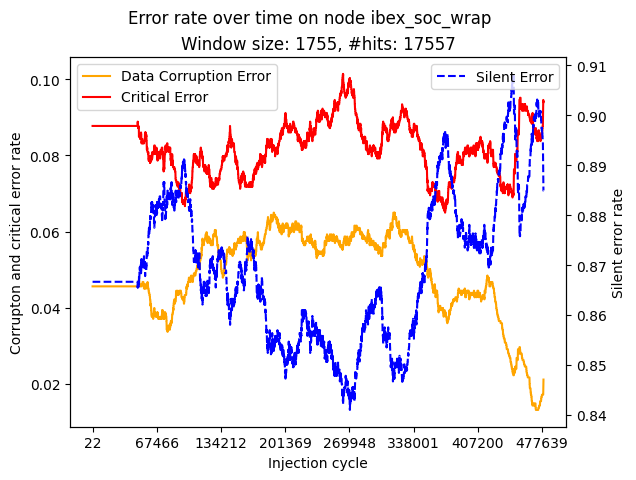

In [23]:
_ = Analyses.error_rate_over_time(register_tree.root, plot=True)

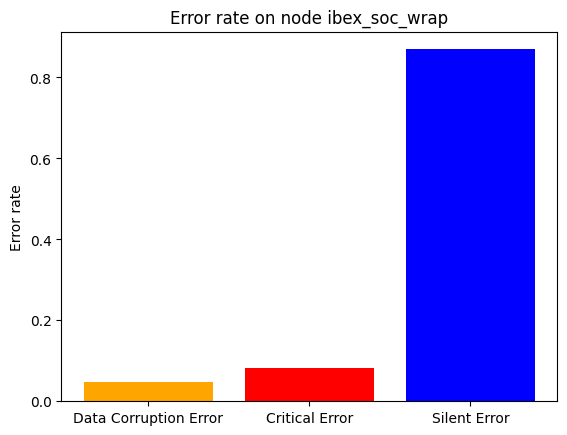

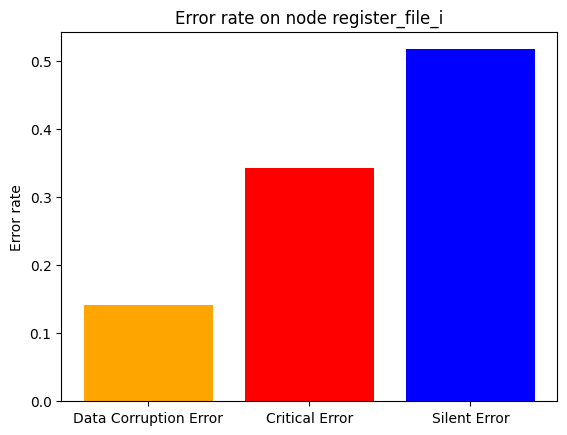

In [22]:
_ = Analyses.error_rate_by_type(register_tree.root, plot=True)
_ = Analyses.error_rate_by_type(node, plot=True)

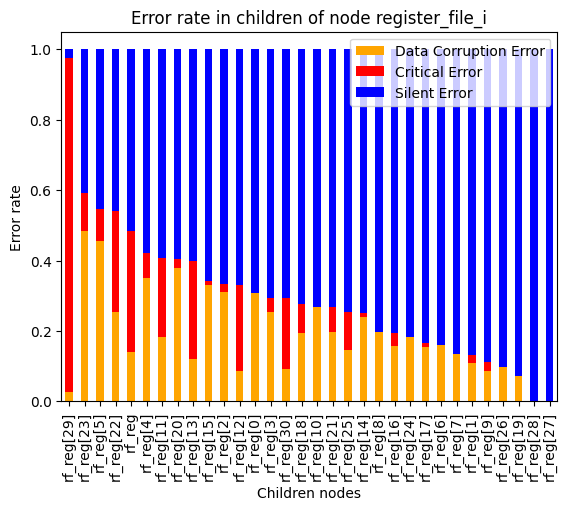

In [18]:
res, fig = Analyses.error_rate_by_type_in_children(node, plot=True)